In [27]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import vgg16

In [28]:
import cv2
from glob import glob
from tqdm import tqdm


In [29]:
birdspath='./Parsed_Capuchinbird_Clips/*'
nobirdspath='./Parsed_Not_Capuchinbird_Clips/*'

In [30]:
import torchaudio

In [31]:
torchaudio.set_audio_backend("soundfile")

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_17054/1822137616.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [32]:
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=1024,       
    win_length=None,  
    hop_length=512,   
    power=2.0       
)

In [33]:
birds=0
nobirds=0

In [34]:
birdspaths=[]
nobirdspaths=[]

In [35]:
import torchaudio
import matplotlib.pyplot as plt
def generateimages(waveform,isbird):
    waveform = waveform.mean(dim=0, keepdim=True)
    spec = torchaudio.transforms.Spectrogram()(waveform)

    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

    plt.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto')
    plt.axis('off')  # optional: remove axes for cleaner image
    if(isbird==1):
        plt.savefig(f"./birdimages/bird{birds+1}.png")
        birdspaths.append((f"./birdimages/bird{birds+1}.png",1))
    else:
        plt.savefig(f"./nobirdimages/nobird{nobirds+1}.png")  
        nobirdspaths.append((f"./nobirdimages/bird{nobirds+1}.png",0))
    plt.savefig("spectrogram_simple.png", dpi=300)

In [36]:
import random
num=0
for i in range(208):
    nobirdspaths.append((f"./nobirdimages/nobird{num+1}.png",0))
    num+=1


In [48]:
num1=0
for j in range(216):
    birdspaths.append((f"./birdimages/bird{num1+1}.png",1))
    num1+=1


In [11]:
allpaths=glob(birdspath)+glob(nobirdspath)
random.shuffle(allpaths)

 35%|███▍      | 207/593 [40:23<1:15:19, 11.71s/it]


KeyboardInterrupt: 

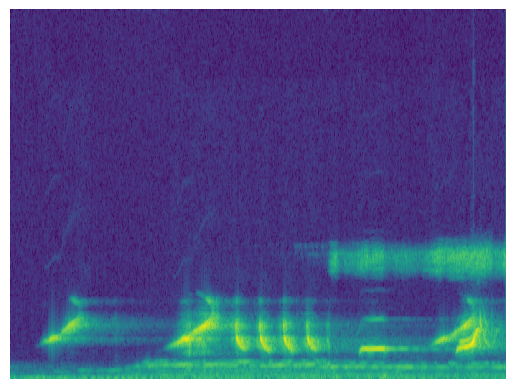

In [ ]:
# for i in tqdm(glob(birdspath)[152:]):
#     waveform,_=torchaudio.load(i)
#     generateimages(waveform,1)
#     birds+=1

# for j in tqdm(glob(nobirdspath)):
#     waveform,_=torchaudio.load(j)
#     generateimages(waveform,0),
#     nobirds+=1
    

In [37]:
from torch.utils.data import Dataset,DataLoader
import cv2
device='cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
tfms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [62]:
from PIL import Image

In [73]:
class getdataset(Dataset):
    def __init__(self, birdspaths, nobirdspaths, transforms=None):
        self.allpaths = birdspaths + nobirdspaths
        random.shuffle(self.allpaths)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.allpaths)

    def __getitem__(self, ix):
        path = self.allpaths[ix]
        
        # Read and convert to RGB using cv2
        image = cv2.imread(path[0])
        
        if image is None:
            raise ValueError(f"Failed to load image: {path[0]}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize using cv2 (since transforms.Resize needs a tensor first)
        image = cv2.resize(image, (224, 224))
        
        # Convert numpy array to tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        # Apply normalization from tfms
        if self.transforms:
            # Extract only the Normalize transform
            normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            image = normalize(image)
        
        # DON'T move to device here!
        label = torch.tensor(path[1], dtype=torch.float32)
        
        return image, label

In [74]:
import math

In [75]:
traindataset=getdataset(birdspaths[:math.floor(len(birdspaths)*0.8)],nobirdspaths[:math.floor(len(nobirdspaths)*0.8)])
valdataset=getdataset(birdspaths[math.floor(len(birdspaths)*0.8):],nobirdspaths[math.floor(len(nobirdspaths)*0.8):])

trainloader=DataLoader(traindataset,batch_size=4,shuffle=True)
valloader=DataLoader(valdataset,batch_size=4,shuffle=True)

In [76]:
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [85]:
import torch.nn as nn
from torchvision import models

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[6] = nn.Linear(4096, 1)

# Only the new layer will be trained
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [86]:
from torch.optim import Adam
from torch import nn

optimizer=Adam(model.parameters(),lr=1e-4)
loss_fn=nn.BCEWithLogitsLoss()

In [87]:
nobirdspaths

[('./nobirdimages/nobird1.png', 0),
 ('./nobirdimages/nobird2.png', 0),
 ('./nobirdimages/nobird3.png', 0),
 ('./nobirdimages/nobird4.png', 0),
 ('./nobirdimages/nobird5.png', 0),
 ('./nobirdimages/nobird6.png', 0),
 ('./nobirdimages/nobird7.png', 0),
 ('./nobirdimages/nobird8.png', 0),
 ('./nobirdimages/nobird9.png', 0),
 ('./nobirdimages/nobird10.png', 0),
 ('./nobirdimages/nobird11.png', 0),
 ('./nobirdimages/nobird12.png', 0),
 ('./nobirdimages/nobird13.png', 0),
 ('./nobirdimages/nobird14.png', 0),
 ('./nobirdimages/nobird15.png', 0),
 ('./nobirdimages/nobird16.png', 0),
 ('./nobirdimages/nobird17.png', 0),
 ('./nobirdimages/nobird18.png', 0),
 ('./nobirdimages/nobird19.png', 0),
 ('./nobirdimages/nobird20.png', 0),
 ('./nobirdimages/nobird21.png', 0),
 ('./nobirdimages/nobird22.png', 0),
 ('./nobirdimages/nobird23.png', 0),
 ('./nobirdimages/nobird24.png', 0),
 ('./nobirdimages/nobird25.png', 0),
 ('./nobirdimages/nobird26.png', 0),
 ('./nobirdimages/nobird27.png', 0),
 ('./nobir

In [88]:
birdspaths

[('./birdimages/bird1.png', 1),
 ('./birdimages/bird2.png', 1),
 ('./birdimages/bird3.png', 1),
 ('./birdimages/bird4.png', 1),
 ('./birdimages/bird5.png', 1),
 ('./birdimages/bird6.png', 1),
 ('./birdimages/bird7.png', 1),
 ('./birdimages/bird8.png', 1),
 ('./birdimages/bird9.png', 1),
 ('./birdimages/bird10.png', 1),
 ('./birdimages/bird11.png', 1),
 ('./birdimages/bird12.png', 1),
 ('./birdimages/bird13.png', 1),
 ('./birdimages/bird14.png', 1),
 ('./birdimages/bird15.png', 1),
 ('./birdimages/bird16.png', 1),
 ('./birdimages/bird17.png', 1),
 ('./birdimages/bird18.png', 1),
 ('./birdimages/bird19.png', 1),
 ('./birdimages/bird20.png', 1),
 ('./birdimages/bird21.png', 1),
 ('./birdimages/bird22.png', 1),
 ('./birdimages/bird23.png', 1),
 ('./birdimages/bird24.png', 1),
 ('./birdimages/bird25.png', 1),
 ('./birdimages/bird26.png', 1),
 ('./birdimages/bird27.png', 1),
 ('./birdimages/bird28.png', 1),
 ('./birdimages/bird29.png', 1),
 ('./birdimages/bird30.png', 1),
 ('./birdimages/bir

In [89]:
from PIL import Image


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.51it/s]


Train Loss: 0.6865 | Train Acc: 0.5207
Val Loss: 0.6387 | Val Acc: 0.8372
✓ Best model saved! Val Acc: 0.8372

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.62it/s]


Train Loss: 0.6141 | Train Acc: 0.7308
Val Loss: 0.5811 | Val Acc: 0.8488
✓ Best model saved! Val Acc: 0.8488

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.52it/s]


Train Loss: 0.5599 | Train Acc: 0.7899
Val Loss: 0.5431 | Val Acc: 0.8837
✓ Best model saved! Val Acc: 0.8837

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.44it/s]


Train Loss: 0.5138 | Train Acc: 0.8639
Val Loss: 0.5013 | Val Acc: 0.8488

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.58it/s]


Train Loss: 0.4786 | Train Acc: 0.8698
Val Loss: 0.4714 | Val Acc: 0.8837

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s]


Train Loss: 0.4569 | Train Acc: 0.8698
Val Loss: 0.4444 | Val Acc: 0.8721

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.24it/s]


Train Loss: 0.4117 | Train Acc: 0.9172
Val Loss: 0.4222 | Val Acc: 0.8721

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.97it/s]


Train Loss: 0.3899 | Train Acc: 0.9231
Val Loss: 0.4079 | Val Acc: 0.9070
✓ Best model saved! Val Acc: 0.9070

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.85it/s]


Train Loss: 0.3959 | Train Acc: 0.8994
Val Loss: 0.3907 | Val Acc: 0.8953

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.85it/s]


Train Loss: 0.3610 | Train Acc: 0.9379
Val Loss: 0.3745 | Val Acc: 0.8721

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.32it/s]


Train Loss: 0.3507 | Train Acc: 0.9260
Val Loss: 0.3638 | Val Acc: 0.9070

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.16it/s]


Train Loss: 0.3460 | Train Acc: 0.9142
Val Loss: 0.3521 | Val Acc: 0.8953

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.03it/s]


Train Loss: 0.3230 | Train Acc: 0.9231
Val Loss: 0.3426 | Val Acc: 0.9070

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.90it/s]


Train Loss: 0.2987 | Train Acc: 0.9438
Val Loss: 0.3341 | Val Acc: 0.9070

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.29it/s]


Train Loss: 0.3093 | Train Acc: 0.9320
Val Loss: 0.3253 | Val Acc: 0.9070

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.87it/s]


Train Loss: 0.2857 | Train Acc: 0.9527
Val Loss: 0.3188 | Val Acc: 0.9070

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.43it/s]


Train Loss: 0.2685 | Train Acc: 0.9497
Val Loss: 0.3106 | Val Acc: 0.9070

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.32it/s]


Train Loss: 0.2678 | Train Acc: 0.9497
Val Loss: 0.3059 | Val Acc: 0.9070

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.69it/s]


Train Loss: 0.2713 | Train Acc: 0.9408
Val Loss: 0.3015 | Val Acc: 0.8953

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.57it/s]


Train Loss: 0.2546 | Train Acc: 0.9497
Val Loss: 0.2970 | Val Acc: 0.9070

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.74it/s]


Train Loss: 0.2532 | Train Acc: 0.9379
Val Loss: 0.2916 | Val Acc: 0.9070

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.68it/s]


Train Loss: 0.2300 | Train Acc: 0.9527
Val Loss: 0.2868 | Val Acc: 0.9070

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.69it/s]


Train Loss: 0.2375 | Train Acc: 0.9438
Val Loss: 0.2830 | Val Acc: 0.9186
✓ Best model saved! Val Acc: 0.9186

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.63it/s]


Train Loss: 0.2102 | Train Acc: 0.9645
Val Loss: 0.2792 | Val Acc: 0.9186

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.67it/s]


Train Loss: 0.2169 | Train Acc: 0.9645
Val Loss: 0.2752 | Val Acc: 0.9070

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.54it/s]


Train Loss: 0.2251 | Train Acc: 0.9467
Val Loss: 0.2721 | Val Acc: 0.9186

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.58it/s]


Train Loss: 0.2214 | Train Acc: 0.9438
Val Loss: 0.2684 | Val Acc: 0.9070

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.65it/s]


Train Loss: 0.1888 | Train Acc: 0.9704
Val Loss: 0.2662 | Val Acc: 0.9186

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.52it/s]


Train Loss: 0.2200 | Train Acc: 0.9438
Val Loss: 0.2651 | Val Acc: 0.9302
✓ Best model saved! Val Acc: 0.9302

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.76it/s]


Train Loss: 0.1975 | Train Acc: 0.9556
Val Loss: 0.2598 | Val Acc: 0.9186

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.89it/s]


Train Loss: 0.1933 | Train Acc: 0.9586
Val Loss: 0.2565 | Val Acc: 0.9070

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.31it/s]


Train Loss: 0.2050 | Train Acc: 0.9408
Val Loss: 0.2552 | Val Acc: 0.9070

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 12.43it/s]


Train Loss: 0.1956 | Train Acc: 0.9615
Val Loss: 0.2520 | Val Acc: 0.9302

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.70it/s]


Train Loss: 0.1927 | Train Acc: 0.9704
Val Loss: 0.2498 | Val Acc: 0.9070

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.63it/s]


Train Loss: 0.1799 | Train Acc: 0.9497
Val Loss: 0.2465 | Val Acc: 0.9186

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.56it/s]


Train Loss: 0.1934 | Train Acc: 0.9438
Val Loss: 0.2449 | Val Acc: 0.9302

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.27it/s]


Train Loss: 0.1855 | Train Acc: 0.9615
Val Loss: 0.2424 | Val Acc: 0.9302

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.96it/s]


Train Loss: 0.1848 | Train Acc: 0.9497
Val Loss: 0.2418 | Val Acc: 0.9302

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.53it/s]


Train Loss: 0.1864 | Train Acc: 0.9527
Val Loss: 0.2392 | Val Acc: 0.9302

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.58it/s]


Train Loss: 0.1755 | Train Acc: 0.9408
Val Loss: 0.2369 | Val Acc: 0.9302

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.24it/s]


Train Loss: 0.1706 | Train Acc: 0.9675
Val Loss: 0.2349 | Val Acc: 0.9302

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.32it/s]


Train Loss: 0.1807 | Train Acc: 0.9615
Val Loss: 0.2323 | Val Acc: 0.9302

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.46it/s]


Train Loss: 0.1728 | Train Acc: 0.9615
Val Loss: 0.2311 | Val Acc: 0.9302

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.82it/s]


Train Loss: 0.1660 | Train Acc: 0.9645
Val Loss: 0.2297 | Val Acc: 0.9302

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.31it/s]


Train Loss: 0.1564 | Train Acc: 0.9615
Val Loss: 0.2293 | Val Acc: 0.9302

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.51it/s]


Train Loss: 0.1721 | Train Acc: 0.9379
Val Loss: 0.2300 | Val Acc: 0.9419
✓ Best model saved! Val Acc: 0.9419

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.61it/s]


Train Loss: 0.1542 | Train Acc: 0.9645
Val Loss: 0.2279 | Val Acc: 0.9419

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.22it/s]


Train Loss: 0.1578 | Train Acc: 0.9675
Val Loss: 0.2276 | Val Acc: 0.9419

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.91it/s]


Train Loss: 0.1537 | Train Acc: 0.9586
Val Loss: 0.2247 | Val Acc: 0.9419

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 14.55it/s]


Train Loss: 0.1387 | Train Acc: 0.9704
Val Loss: 0.2257 | Val Acc: 0.9419

Training Complete!
Best Validation Accuracy: 0.9419


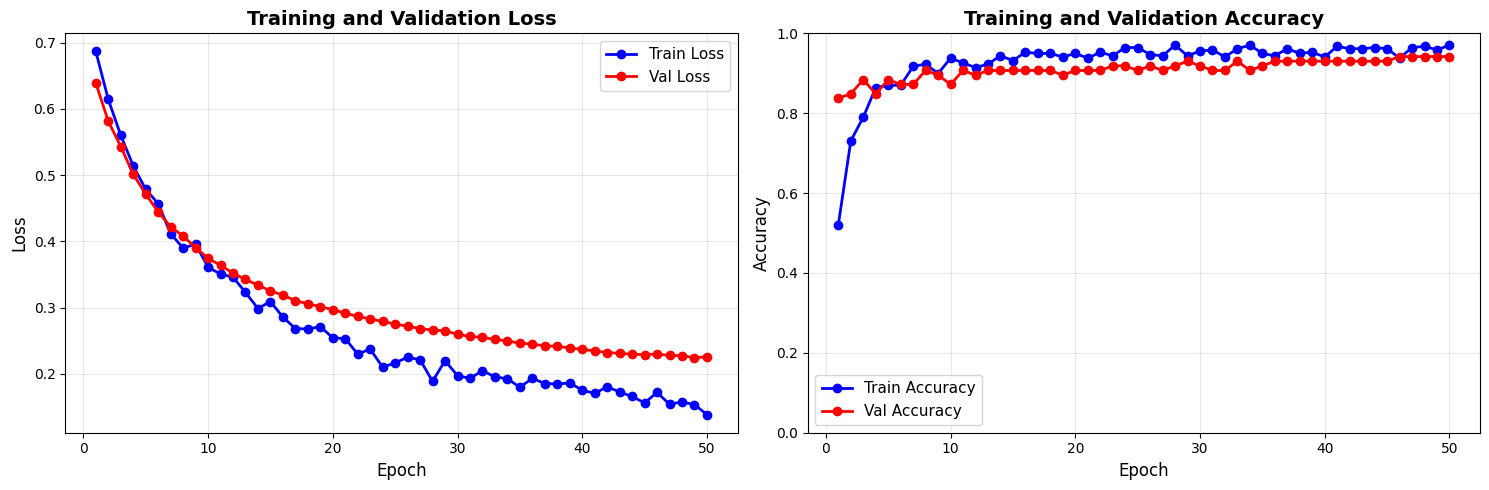


FINAL STATISTICS
Final Train Loss: 0.1387
Final Train Accuracy: 0.9704
Final Val Loss: 0.2257
Final Val Accuracy: 0.9419
Best Val Accuracy: 0.9419


In [90]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

epochs = 50
best_val_acc = 0.0

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    print('-' * 50)
    
    # ========== TRAINING PHASE ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(trainloader, desc='Training'):
        images, labels = batch
        labels = labels.float().unsqueeze(1).to(device)  # Shape: [batch_size, 1]
        images = images.to(device)
        
        # Forward pass
        preds = model(images)
        loss = loss_fn(preds, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(preds) > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Calculate training metrics
    epoch_train_loss = train_loss / train_total
    epoch_train_acc = train_correct / train_total
    
    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(valloader, desc='Validation'):
            images, labels = batch
            labels = labels.float().unsqueeze(1).to(device)
            images = images.to(device)
            
            # Forward pass
            preds = model(images)
            loss = loss_fn(preds, labels)
            
            # Track metrics
            val_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(preds) > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    
    # Save metrics
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    # Print epoch summary
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'✓ Best model saved! Val Acc: {best_val_acc:.4f}')

print('\n' + '='*50)
print('Training Complete!')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# ========== VISUALIZATION ==========
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(range(1, epochs+1), history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(range(1, epochs+1), history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(range(1, epochs+1), history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
axes[1].plot(range(1, epochs+1), history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print('\n' + '='*50)
print('FINAL STATISTICS')
print('='*50)
print(f'Final Train Loss: {history["train_loss"][-1]:.4f}')
print(f'Final Train Accuracy: {history["train_acc"][-1]:.4f}')
print(f'Final Val Loss: {history["val_loss"][-1]:.4f}')
print(f'Final Val Accuracy: {history["val_acc"][-1]:.4f}')
print(f'Best Val Accuracy: {best_val_acc:.4f}')

In [94]:
from torchvision import models
modelres = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in modelres.parameters():
    param.requires_grad = False

modelres.fc = nn.Linear(2048, 1)
modelres.to(device)

# Important: Only optimize the new fc layer parameters
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(modelres.fc.parameters(), lr=0.001)


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.92it/s]


Train Loss: 0.5953 | Train Acc: 0.6538
Val Loss: 0.3665 | Val Acc: 0.8605
✓ Best model saved! Val Acc: 0.8605

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.10it/s]


Train Loss: 0.3803 | Train Acc: 0.8609
Val Loss: 0.3142 | Val Acc: 0.8488

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.74it/s]


Train Loss: 0.4028 | Train Acc: 0.8077
Val Loss: 0.5137 | Val Acc: 0.7558

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.18it/s]


Train Loss: 0.3581 | Train Acc: 0.8343
Val Loss: 0.2338 | Val Acc: 0.9186
✓ Best model saved! Val Acc: 0.9186

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 17.55it/s]


Train Loss: 0.2579 | Train Acc: 0.8905
Val Loss: 0.1953 | Val Acc: 0.9186

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.46it/s]


Train Loss: 0.3623 | Train Acc: 0.8373
Val Loss: 0.2363 | Val Acc: 0.8605

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.62it/s]


Train Loss: 0.3333 | Train Acc: 0.8462
Val Loss: 0.2636 | Val Acc: 0.8721

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.69it/s]


Train Loss: 0.2306 | Train Acc: 0.9083
Val Loss: 0.2301 | Val Acc: 0.8953

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.70it/s]


Train Loss: 0.2373 | Train Acc: 0.8994
Val Loss: 0.1713 | Val Acc: 0.9302
✓ Best model saved! Val Acc: 0.9302

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.38it/s]


Train Loss: 0.3291 | Train Acc: 0.8521
Val Loss: 0.2072 | Val Acc: 0.8953

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.47it/s]


Train Loss: 0.2420 | Train Acc: 0.8964
Val Loss: 0.1733 | Val Acc: 0.9419
✓ Best model saved! Val Acc: 0.9419

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 17.17it/s]


Train Loss: 0.2450 | Train Acc: 0.9024
Val Loss: 0.2677 | Val Acc: 0.8721

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.58it/s]


Train Loss: 0.3165 | Train Acc: 0.8669
Val Loss: 0.1891 | Val Acc: 0.9186

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.57it/s]


Train Loss: 0.2757 | Train Acc: 0.9053
Val Loss: 0.1846 | Val Acc: 0.9070

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.03it/s]


Train Loss: 0.2819 | Train Acc: 0.8876
Val Loss: 0.1546 | Val Acc: 0.9419

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.70it/s]


Train Loss: 0.2651 | Train Acc: 0.8846
Val Loss: 0.1474 | Val Acc: 0.9419

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.57it/s]


Train Loss: 0.2647 | Train Acc: 0.8876
Val Loss: 0.2025 | Val Acc: 0.8837

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.62it/s]


Train Loss: 0.2141 | Train Acc: 0.9172
Val Loss: 0.1806 | Val Acc: 0.9186

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.64it/s]


Train Loss: 0.1925 | Train Acc: 0.9231
Val Loss: 0.2295 | Val Acc: 0.8953

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.31it/s]


Train Loss: 0.2348 | Train Acc: 0.8935
Val Loss: 0.1766 | Val Acc: 0.9070

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 16.87it/s]


Train Loss: 0.2153 | Train Acc: 0.9053
Val Loss: 0.2103 | Val Acc: 0.8953

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.00it/s]


Train Loss: 0.3000 | Train Acc: 0.8698
Val Loss: 0.1716 | Val Acc: 0.9186

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.12it/s]


Train Loss: 0.2247 | Train Acc: 0.9024
Val Loss: 0.1739 | Val Acc: 0.9186

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.95it/s]


Train Loss: 0.1824 | Train Acc: 0.9142
Val Loss: 0.1529 | Val Acc: 0.9302

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.78it/s]


Train Loss: 0.2957 | Train Acc: 0.8728
Val Loss: 0.2542 | Val Acc: 0.8721

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.95it/s]


Train Loss: 0.2111 | Train Acc: 0.9112
Val Loss: 0.2113 | Val Acc: 0.8721

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.30it/s]


Train Loss: 0.2410 | Train Acc: 0.8964
Val Loss: 0.1262 | Val Acc: 0.9419

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.83it/s]


Train Loss: 0.2476 | Train Acc: 0.8757
Val Loss: 0.1838 | Val Acc: 0.9070

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.34it/s]


Train Loss: 0.1551 | Train Acc: 0.9408
Val Loss: 0.1603 | Val Acc: 0.9419

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.15it/s]


Train Loss: 0.2455 | Train Acc: 0.8964
Val Loss: 0.1294 | Val Acc: 0.9419

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.47it/s]


Train Loss: 0.2104 | Train Acc: 0.9112
Val Loss: 0.1872 | Val Acc: 0.8953

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.49it/s]


Train Loss: 0.2103 | Train Acc: 0.9142
Val Loss: 0.1830 | Val Acc: 0.9070

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.20it/s]


Train Loss: 0.2928 | Train Acc: 0.8757
Val Loss: 0.3048 | Val Acc: 0.8721

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.58it/s]


Train Loss: 0.2898 | Train Acc: 0.8876
Val Loss: 0.1248 | Val Acc: 0.9535
✓ Best model saved! Val Acc: 0.9535

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.39it/s]


Train Loss: 0.2234 | Train Acc: 0.9083
Val Loss: 0.2013 | Val Acc: 0.8837

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.45it/s]


Train Loss: 0.2197 | Train Acc: 0.9024
Val Loss: 0.2139 | Val Acc: 0.8721

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.34it/s]


Train Loss: 0.2343 | Train Acc: 0.8846
Val Loss: 0.1654 | Val Acc: 0.9186

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.25it/s]


Train Loss: 0.2963 | Train Acc: 0.8580
Val Loss: 0.2168 | Val Acc: 0.9186

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.26it/s]


Train Loss: 0.2047 | Train Acc: 0.9201
Val Loss: 0.1473 | Val Acc: 0.9302

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.39it/s]


Train Loss: 0.2141 | Train Acc: 0.8935
Val Loss: 0.1692 | Val Acc: 0.9070

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


Train Loss: 0.2339 | Train Acc: 0.9024
Val Loss: 0.1447 | Val Acc: 0.9302

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 19.32it/s]


Train Loss: 0.1309 | Train Acc: 0.9527
Val Loss: 0.1526 | Val Acc: 0.9302

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 17.75it/s]


Train Loss: 0.2106 | Train Acc: 0.9290
Val Loss: 0.2087 | Val Acc: 0.8953

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 18.21it/s]


Train Loss: 0.1498 | Train Acc: 0.9379
Val Loss: 0.2154 | Val Acc: 0.8953

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 17.46it/s]


Train Loss: 0.1580 | Train Acc: 0.9497
Val Loss: 0.2122 | Val Acc: 0.8953

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.54it/s]


Train Loss: 0.2183 | Train Acc: 0.9053
Val Loss: 0.1767 | Val Acc: 0.9070

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.24it/s]


Train Loss: 0.2762 | Train Acc: 0.8994
Val Loss: 0.1152 | Val Acc: 0.9535

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 12.48it/s]


Train Loss: 0.2268 | Train Acc: 0.9053
Val Loss: 0.3100 | Val Acc: 0.8837

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 13.88it/s]


Train Loss: 0.1405 | Train Acc: 0.9497
Val Loss: 0.2133 | Val Acc: 0.8837

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 22/22 [00:01<00:00, 15.53it/s]


Train Loss: 0.2074 | Train Acc: 0.9112
Val Loss: 0.1846 | Val Acc: 0.9070

Training Complete!
Best Validation Accuracy: 0.9535


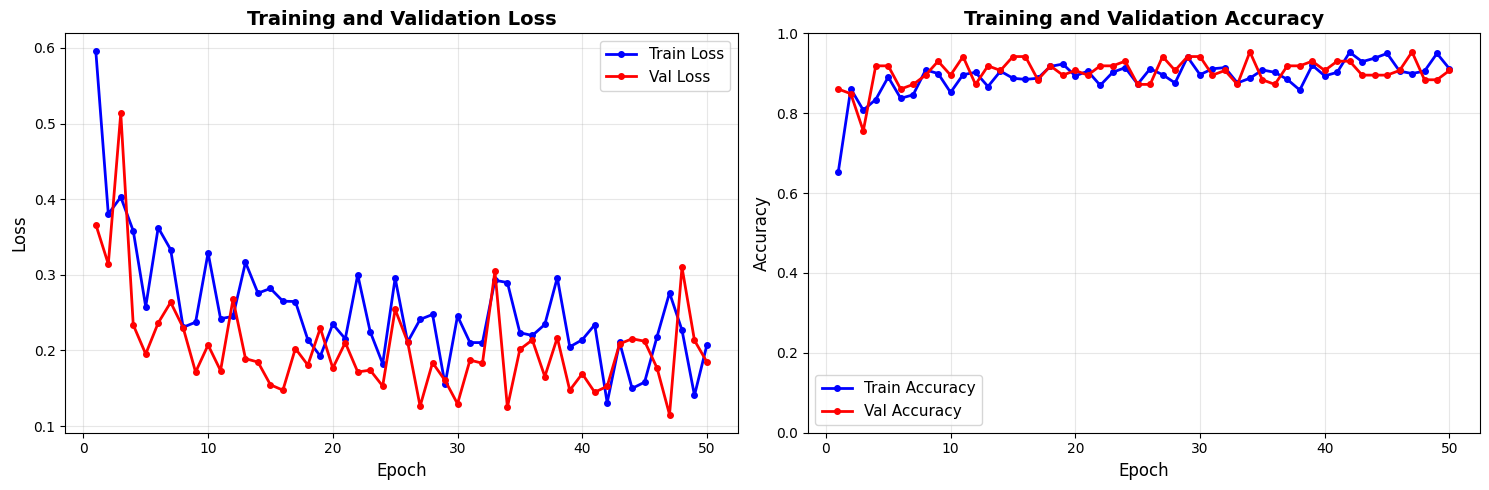


FINAL STATISTICS
Final Train Loss: 0.2074
Final Train Accuracy: 0.9112
Final Val Loss: 0.1846
Final Val Accuracy: 0.9070
Best Val Accuracy: 0.9535


In [95]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

epochs = 50
best_val_acc = 0.0

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    print('-' * 50)
    
    # ========== TRAINING PHASE ==========
    modelres.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(trainloader, desc='Training'):
        images, labels = batch
        labels = labels.float().unsqueeze(1).to(device)  # Shape: [batch_size, 1]
        images = images.to(device)
        
        # Forward pass
        preds = modelres(images)
        loss = loss_fn(preds, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(preds) > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Calculate training metrics
    epoch_train_loss = train_loss / train_total
    epoch_train_acc = train_correct / train_total
    
    # ========== VALIDATION PHASE ==========
    modelres.eval()  # Fixed: was model.eval(), should be modelres.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(valloader, desc='Validation'):
            images, labels = batch
            labels = labels.float().unsqueeze(1).to(device)
            images = images.to(device)
            
            # Forward pass
            preds = modelres(images)
            loss = loss_fn(preds, labels)
            
            # Track metrics
            val_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(preds) > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    
    # Save metrics
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    # Print epoch summary
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(modelres.state_dict(), 'best_resnet_model.pth')  # Changed filename
        print(f'✓ Best model saved! Val Acc: {best_val_acc:.4f}')

print('\n' + '='*50)
print('Training Complete!')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# ========== VISUALIZATION ==========
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(range(1, epochs+1), history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
axes[0].plot(range(1, epochs+1), history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(range(1, epochs+1), history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2, markersize=4)
axes[1].plot(range(1, epochs+1), history['val_acc'], 'r-o', label='Val Accuracy', linewidth=2, markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('resnet_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print('\n' + '='*50)
print('FINAL STATISTICS')
print('='*50)
print(f'Final Train Loss: {history["train_loss"][-1]:.4f}')
print(f'Final Train Accuracy: {history["train_acc"][-1]:.4f}')
print(f'Final Val Loss: {history["val_loss"][-1]:.4f}')
print(f'Final Val Accuracy: {history["val_acc"][-1]:.4f}')
print(f'Best Val Accuracy: {best_val_acc:.4f}')